# Classificació de senyals de trànsit amb LeNet-5 
by **Bruna da Silva**

---
## Pas 0: Importa les llibreries i les dades
Importem les llibreries que necessitem per aquest projecte i, en aquest cas, el dataset GTSRB: https://benchmark.ini.rub.de/gtsrb_dataset.html

In [1]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

In [2]:
images = []
labels = []
classes = 43

current_path = 'training/'

for i in range(classes):
    path = os.path.join(current_path, str(str(i).zfill(5)))
    img_folder = os.listdir(path)
    for j in img_folder:
        try:
            image = cv.imread(str(path+'/'+j))
            image = cv.resize(image, (32, 32))
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = np.array(image)
            images.append(image)
            label = np.zeros(classes)
            label[i] = 1.0
            labels.append(label)
        except:
            pass

images = np.array(images)
labels = np.array(labels)

---
## Pas 1: Exploració i resum de les dades

### 1. Divisió de les dades
Del dataset sencer, un 75% de les dades seran d'entrenament, un 15% de validació, i un 10% de test.

In [3]:
X = images.astype(np.int16)
y = labels.astype(np.float32)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=123) 

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (19980, 32, 32, 3)
y_train shape: (19980, 43)
X_valid shape: (3996, 32, 32, 3)
y_valid shape: (3996, 43)
X_test shape: (2664, 32, 32, 3)
y_test shape: (2664, 43)


### 2. Resum bàsic del dataset
Obtenim informació del dataset.

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image
image_shape = X_train.shape[1:4]

# How many unique classes/labels there are in the dataset
n_classes = np.unique(ar=y_train).shape[0]

image_depth_dimension = X_train.shape[3]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 19980
Number of testing examples = 2664
Image data shape = (32, 32, 3)
Number of classes = 2


Les imatges són de 32x32x3, és a dir, imatges en color d'una resolució molt baixa. A partir d'algunes escollides a l'atzar podem observar com són les imatges del dataset.

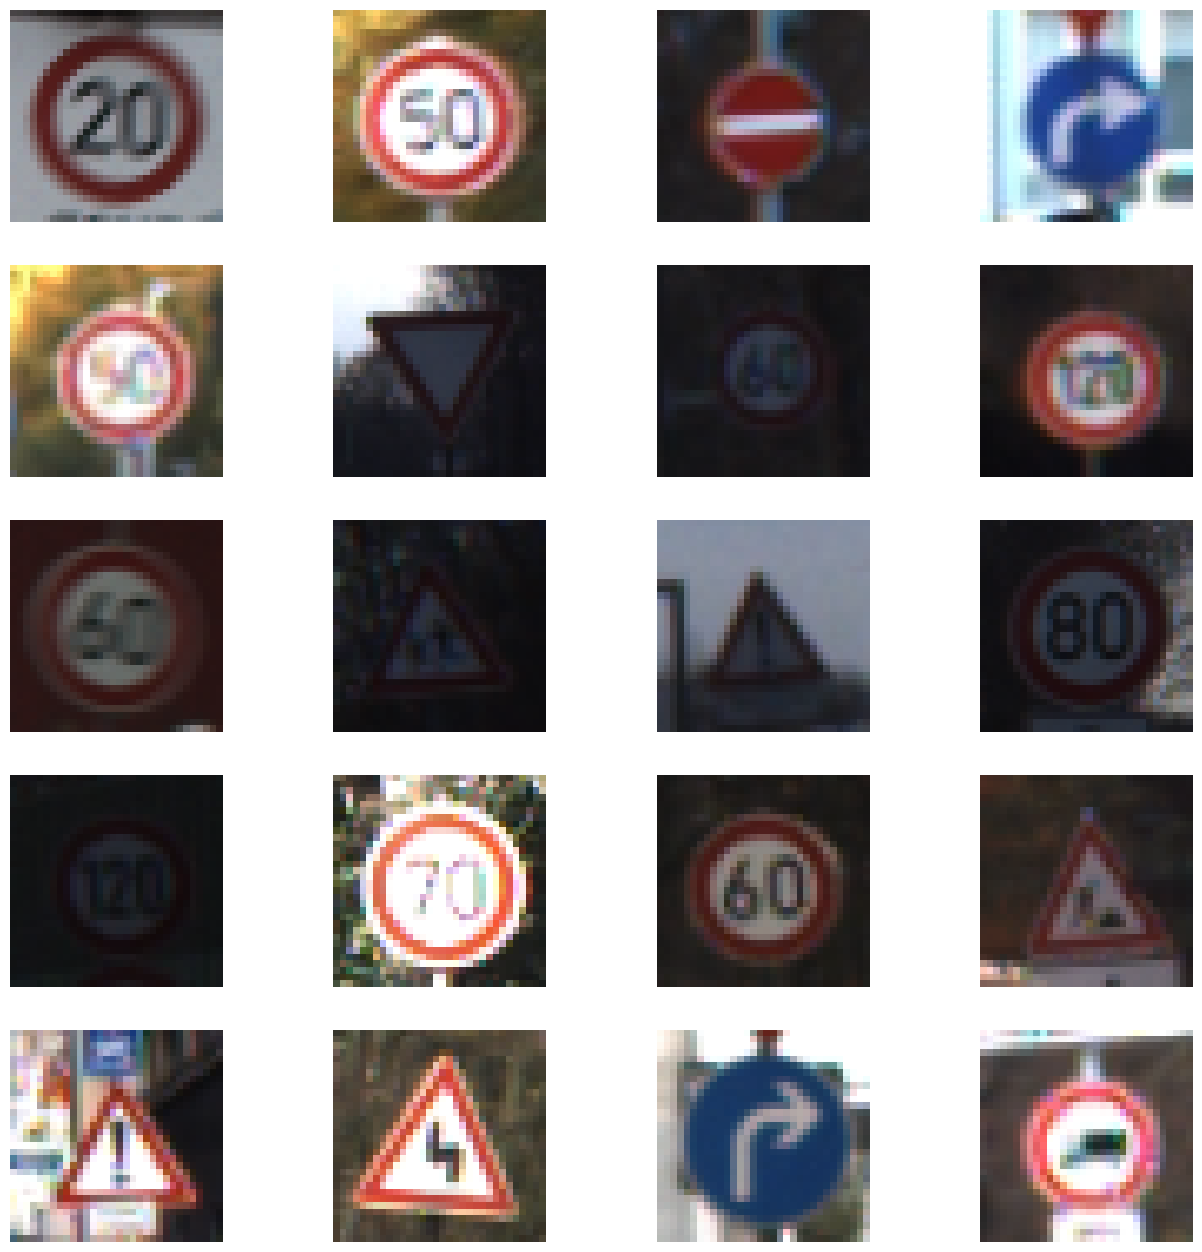

In [5]:
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook
# %matplotlib inline
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Show random images from the dataset
    img = X_train[randint(0, n_train-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')   
plt.show()

---
## Pas 2: Preprocessament de les imatges

### 1. Normalització

In [6]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [length, width, color_depth]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

normalized_train = np.zeros([n_train,32,32,3])
normalized_validation = np.zeros([n_validation,32,32,3])
normalized_test = np.zeros([n_test,32,32,3])
for i in range(0,n_train):
    normalized_train[i] = normalize(X_train[i])
for i in range(0,n_validation):
    normalized_validation[i] = normalize(X_valid[i])
for i in range(0,n_test):
    normalized_test[i] = normalize(X_test[i])

assert(X_train.shape==normalized_train.shape)

### 2. Mostrem la diferència que marca la normalització

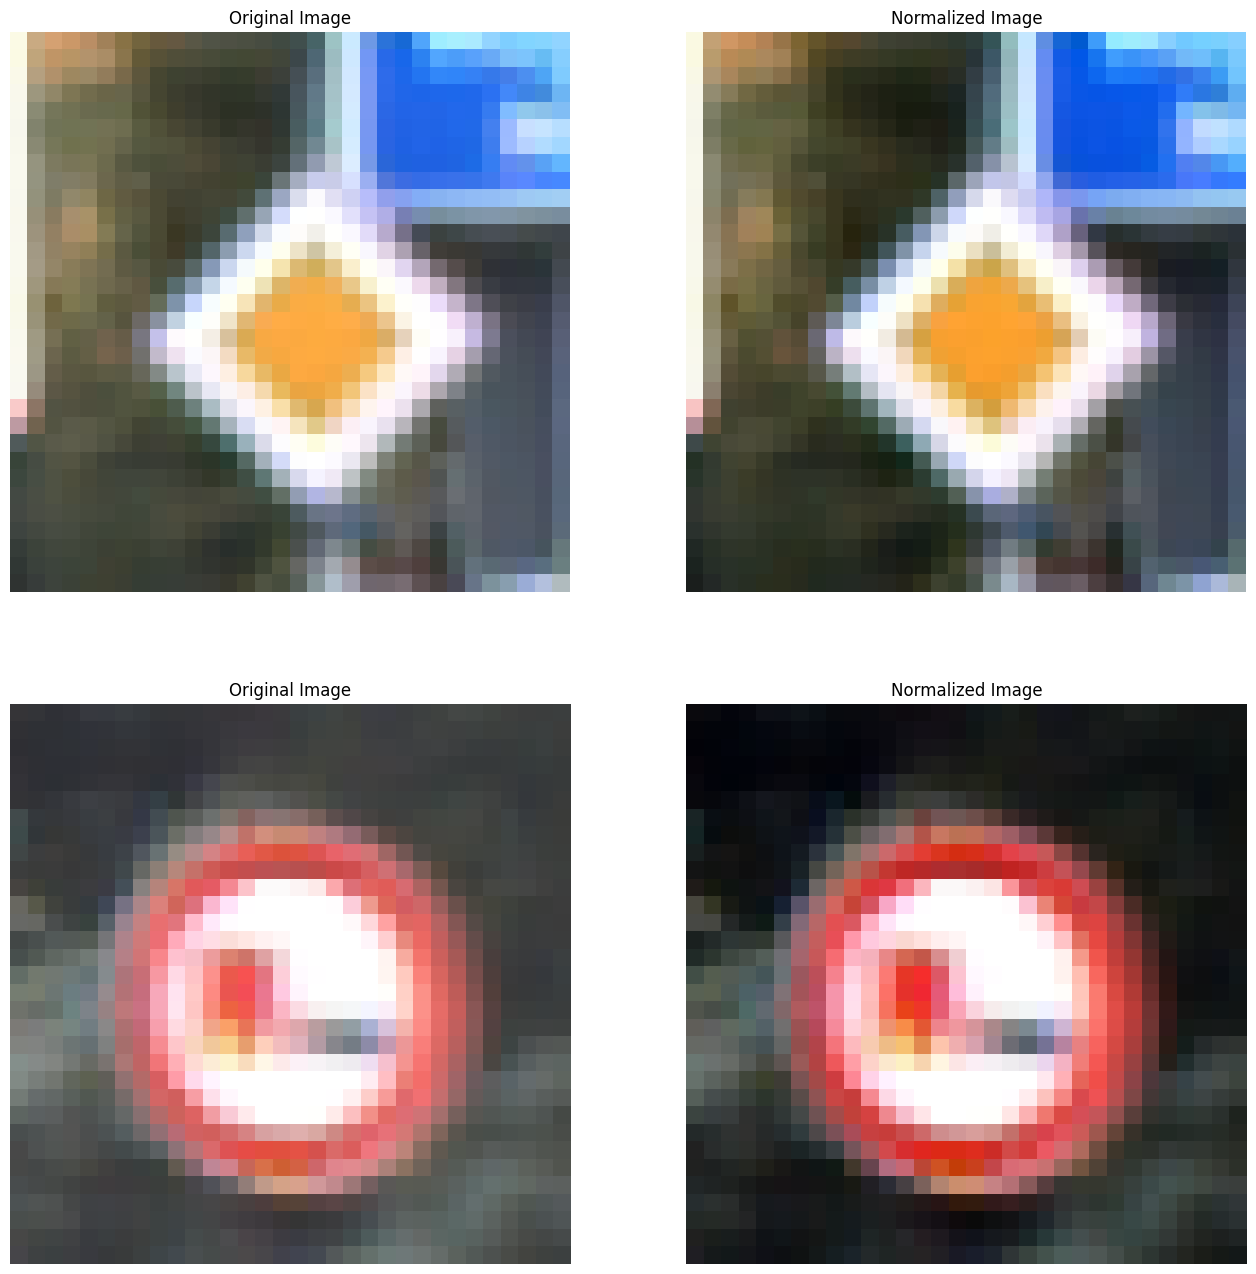

In [7]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16))
randomindex = randint(0,n_train-1)
axarr[0,0].imshow(X_train[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original Image')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Normalized Image')
randomindex = randint(0,n_train-1)
axarr[1,0].imshow(X_train[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Original Image')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Normalized Image')

plt.show()

### 3. Fem que les imatges normalitzades siguin les que es facin servir 

In [8]:
X_train = normalized_train

X_valid = normalized_validation

X_test = normalized_test

---
## Pas 3: Construim el model

In [9]:
# Building the model

from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilation of the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

2024-09-03 19:54:26.915281: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 19:54:26.918437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 19:54:26.927993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 19:54:26.942126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 19:54:26.946170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 19:54:26.955905: I tensorflow/core/platform/cpu_feature_gu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,715 (276.23 KB)

 Trainable params: 70,715 (276.23 KB)

 Non-trainable params: 0 (0.00 B)

---
## Pas 4: Entrenem el model

In [10]:
# Training the model
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))
# save the model
model.save('./model/lenet.keras')


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3151 - loss: 2.5450 - val_accuracy: 0.8396 - val_loss: 0.5909
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8098 - loss: 0.6202 - val_accuracy: 0.9044 - val_loss: 0.3396
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8769 - loss: 0.3906 - val_accuracy: 0.9337 - val_loss: 0.2603
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9113 - loss: 0.2803 - val_accuracy: 0.9587 - val_loss: 0.1682
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9361 - loss: 0.2088 - val_accuracy: 0.9645 - val_loss: 0.1541
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9472 - loss: 0.1699 - val_accuracy: 0.9662 - val_loss: 0.1422
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9534 - loss: 0.1482 - val_accuracy: 0.9702 - val_loss: 0.1178
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9650 - loss: 0.1107 - val_accuracy: 0.

---
## Pas 5: Evaluem

In [11]:
model = load_model('./model/lenet.keras')

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print('\Training accuracy:', train_acc)
print('\Training loss:', train_loss)

valid_loss, valid_acc = model.evaluate(X_valid, y_valid, verbose=2)
print('\nValidation accuracy:', valid_acc)
print('\nValidation loss:', valid_loss)

# Testing the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

625/625 - 2s - 3ms/step - accuracy: 0.9997 - loss: 0.0012
\Training accuracy: 0.9997497200965881
\Training loss: 0.0012004597811028361
125/125 - 0s - 2ms/step - accuracy: 0.9927 - loss: 0.0674

Validation accuracy: 0.9927427172660828

Validation loss: 0.06737461686134338
84/84 - 0s - 3ms/step - accuracy: 0.9891 - loss: 0.0742

Test accuracy: 0.9891141057014465

Test loss: 0.07423681765794754


In [12]:
# save the model
model.save('./model/lenet.keras')

---
## Pas 6: Provem el model en imatges noves

In [23]:
import pandas as pd
input = pd.read_csv("Noms_senyals.csv")
class_names = input.nom

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


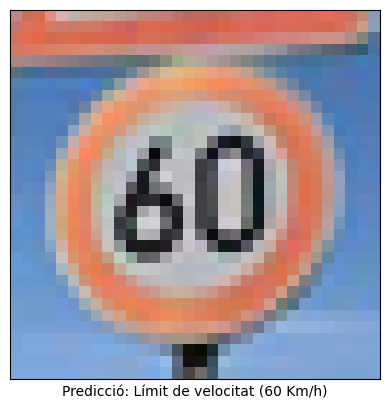

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


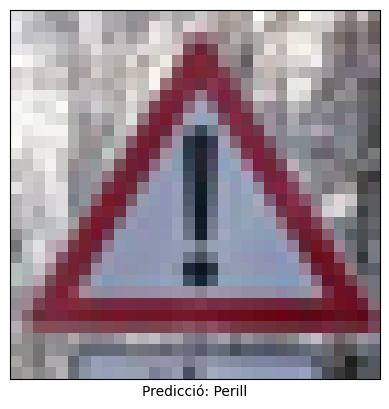

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


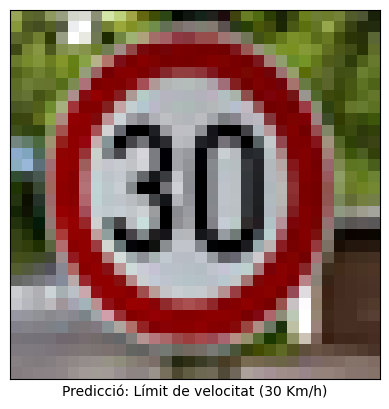

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


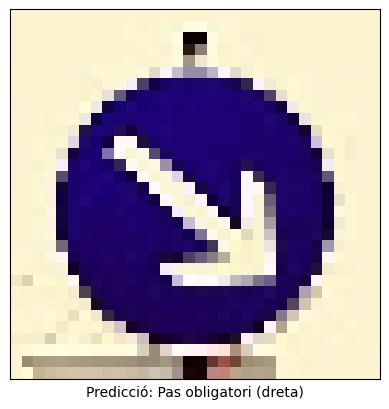

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


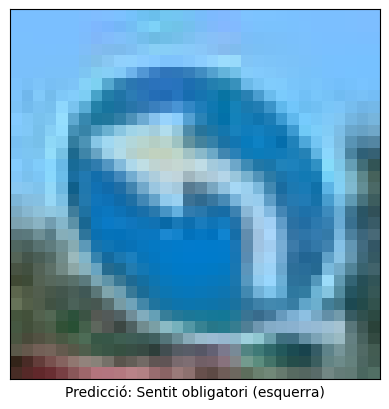

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


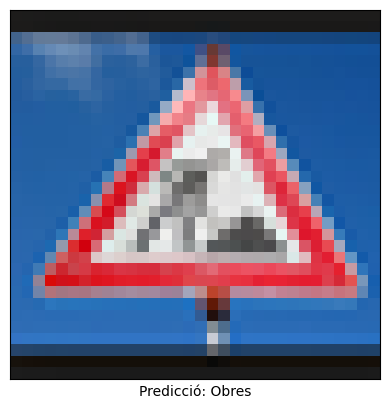

In [24]:
# Predictions
model = load_model('./model/lenet.keras')

my_images_path = './mysigns/'
my_images_folder = os.listdir(my_images_path)

for file_name in my_images_folder:
    img = cv.imread(my_images_path + file_name)
    img = cv.resize(img, (32, 32))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.array(img)

    img = img.astype(np.int16)
    img = normalize(img)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img = img.reshape(1, 32, 32, 3)
    pred = model.predict(img)
    pred_class = np.argmax(pred)
    pred_label = class_names[pred_class]

    plt.xlabel('Predicció: ' + pred_label)
    plt.show()